# Grad-CAM and FGSM

- Andrei Dugăeșescu

<br>

In this notebook we explore two (very) distinct applications of gradients in the context of deep learning, namely Grad-CAM and FGSM.

- **Grad-CAM** (Gradient-weighted Class Activation Mapping) is a visualization technique that helps us understand which parts of an input image are most important for a neural network's prediction. 
<br>

- **FGSM** (Fast Gradient Sign Method) on the other hand is an adversarial attack method that uses gradients to manipulate the input image by adding small meaningful perturbations in order to fool the model - causing it to make incorrect  predictions.

<div align="center">
  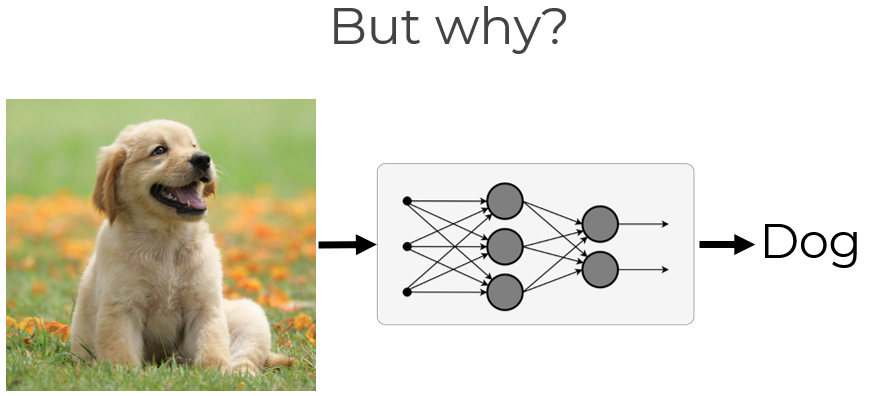
</div>

In [1]:
from torchvision import transforms as tf
from pathlib import Path
from torch import Tensor
from PIL import Image

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torchvision
import torch
import json
import cv2
import os

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Setting up the model - ResNet34

In [3]:
model = torchvision.models.resnet34(weights='DEFAULT')

model = model.to(device)
model = model.eval()

In [4]:
target_layer = model.layer4[-1]

# Activations and Gradients 

In [5]:
class ActivationsAndGradients:
    
    def __init__(self, model: nn.Module, target_layer: nn.Module) -> None:
        self.model = model
        self.gradients, self.activations = None, None
        
        self.hook_activations = target_layer.register_forward_hook(self.save_activation)
        self.hook_gradients = target_layer.register_forward_hook(self.save_gradient)
        
    def save_activation(self, module, input, output):
        self.activations = output.cpu().detach()
        
    def save_gradient(self, module, input, output):
        
        def _store_grad(grad):
            self.gradients = grad.cpu().detach()
    
        output.register_hook(_store_grad)
        
    def __call__(self, x: Tensor) -> Tensor:
        self.gradients, self.activations = None, None
        return self.model(x)
    
    def release(self):
        self.hook_activations.remove()
        self.hook_gradients.remove()

# Implementing Grad-CAM

One of the most important efforts in explaining the decision process of a deep convolutional neural network through a visual explanation is the methodology proposed in [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150) called Class Activation Mapping (CAM).

<div align="center">
  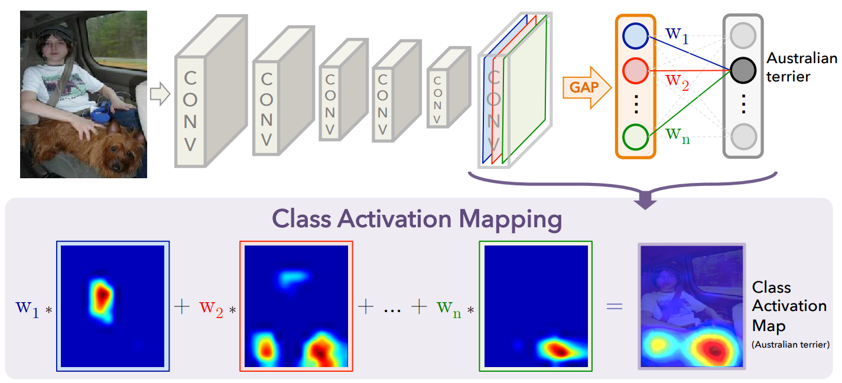
</div>

The idea of CAM is quite simple - the explanation for any input is just a linear combination of feature maps from a target layer (usually the last convolutional layer). Each feature map from the targeted activations is scaled by a score that should be representative of how important it was with regards to the final prediction (more important feature maps should have higher scores). 
By then summing up the scaled activation maps we obtain a single channel heatmap that highlights the salient areas in the ensuing activations. To then translate this to the original pixel space, we need to upscale this explanation to match the size of the input since, by design, its spatial resolution is limited to that of the activations from the targeted layer.

For **Grad-CAM** the scores are computed as the global mean of the gradients corresponding to the target layer. Henceforth, **Grad-CAM** only requires a single forward and backward pass to generate the explanation for a batch of inputs. 

In [6]:
class GradCAM:
    
    def __init__(self, model: nn.Module, target_layer: nn.Module) -> None:
        
        self.model = model
        self.activations_and_grads = ActivationsAndGradients(model, target_layer)
        
    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
    
    def normalize(self, cam: np.ndarray) -> np.ndarray:
        return np.float32([(x - x.min()) / (x.max() - x.min() + 1e-7) for x in cam])
    
    def scale(self, cam: np.ndarray, target_size: tuple[int, int]) -> np.ndarray:
        return np.float32([cv2.resize(x, target_size) for x in cam])
        
    def __call__(self, input_tensor: Tensor, class_idxs: int | None = None) -> np.ndarray:
        
        # Get the activations and gradients by running the input through the model
        # and running a backward pass (for the gradients)
        input_tensor = input_tensor.to(device)
        output = self.activations_and_grads(input_tensor)
        
        if class_idxs is None:
            class_idxs = np.argmax(output.cpu().data.numpy(), axis=-1)
        
        self.model.zero_grad()
        loss = output[:, class_idxs].sum()
        _ = loss.backward(retain_graph=True)
        
        activations = self.activations_and_grads.activations.cpu().data.numpy()
        gradients = self.activations_and_grads.gradients.cpu().data.numpy()
        
        # Compute the GradCAM weights
        weights = np.mean(gradients, axis=(2, 3))
        
        # Construct the heatmap
        cam = (weights[:, :, None, None] * activations).sum(axis=1)
        
        # Post process the heatmap
        cam = np.maximum(cam, 0)   # Only keep positive influences
        cam = self.normalize(cam)  # Normalize to [0, 1] range
        cam = self.scale(cam, input_tensor.shape[-2:])  # Scale to the size of the input
        
        return cam

# Helpers 

In [7]:
def preprocess_image(image: Image.Image) -> Tensor:
    preprocessing = tf.Compose([
        tf.Resize((224, 224)),
        tf.ToTensor(),
        tf.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    
    return preprocessing(image).unsqueeze(0)

In [8]:
def display(image: Image.Image, heatmap: np.ndarray, figsize: tuple[int, int] = (5, 5)) -> None:
    image = np.array(image)
    
    plt.subplots(figsize=figsize)
    plt.axis('off')
    
    explanation = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    explanation = cv2.cvtColor(explanation, cv2.COLOR_BGR2RGB)
    explanation = cv2.addWeighted(image, 0.6, explanation, 0.4, 0)
    explanation = explanation / np.max(explanation)
    explanation = np.uint8(255 * explanation)
    
    plt.imshow(explanation)
    plt.show()

# Explaining where the model looks in the image 

## Loading in an example to be explained 

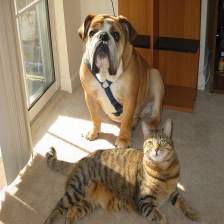

In [9]:
image = Image.open('data/both.png')
input_tensor = preprocess_image(image)
image

## Grad-CAM 

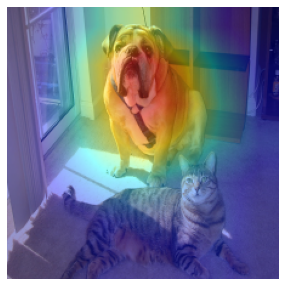

In [10]:
grad_cam = GradCAM(model, target_layer)
heatmap = grad_cam(input_tensor)[0]  # output is of shape (1, 224, 224)
display(image, heatmap)

<br>

# Adversarial attacks

Adversarial attacks are specially curated inputs designed to trick or fool a model. In this notebook we discuss about adversarial attacks on deep image classification models. Deep Neural Networks (DNNs) are powerful tools that can learn patterns and structure in data in order to achieve remarkable performance on a wide variety of tasks. The surprising thing however is how easily they can be swayed  to make an erroneous prediction. For instance, consider the following example from a 2014 study by [Goodfellow *et al.*](https://arxiv.org/pdf/1412.6572):

<div align="center">
  
</div>

## Helpers 

In [11]:
with open('data/label_list.json', 'r') as f:
    label_names = json.load(f)  # Load in human-readable ImageNet labels
label_names[:5]

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']

In [12]:
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

In [13]:
def tensor_to_image(image_tensor: Tensor) -> np.ndarray:
    image = image_tensor.cpu().permute(1, 2, 0).numpy()
    image = image * std + mean
    return np.clip(image, 0., 1.)

In [14]:
def show_prediction(
    image: Tensor, 
    label: Tensor,
    pred: Tensor,
    adv_image: Tensor | None = None,
    noise: Tensor | None = None,
    k: int = 5
) -> None:
    
    image, label = tensor_to_image(image), label.item()
    n_cols = 2 if adv_image is None and noise is None else 5
    
    if n_cols == 2:
        fig, ax = plt.subplots(1, 2, figsize=(13, 3), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(18, 3), gridspec_kw={'width_ratios': [1, 1, 1, 0.5, 2]})
            
    ax[0].imshow(image)
    ax[0].set_title(label_names[label], fontsize=14)
    ax[0].axis('off')
    
    if n_cols == 5:
        ax[1].imshow(tensor_to_image(adv_image))
        ax[1].set_title('Adversarial')
        ax[1].axis('off')

        ax[2].imshow((noise.cpu().permute(1, 2, 0).numpy() * 0.5) + 0.5)
        ax[2].set_title('Noise')
        ax[2].axis('off')

        ax[3].axis('off')
                     
    pred = F.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(k, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().detach().numpy(), topk_idx.cpu().detach().numpy()
    colors = ["C0" if topk_idx[i] != label else "C2" for i in range(k)]
    
    ax[-1].barh(np.arange(k), topk_vals * 100.0, align='center', color=colors)
    ax[-1].set_yticks(np.arange(k))
    ax[-1].set_xticks(np.linspace(0, 100, 6))
    ax[-1].tick_params(axis='both', which='major', labelsize=14)
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence', fontsize=14)
    ax[-1].set_title('Predictions', fontsize=14)

    plt.show()
    plt.close()

## Preparing a batch to attack the model 

In [15]:
BASE_PATH = Path('data/batch')
image_paths = [f for f in os.listdir(BASE_PATH)]
images = torch.stack([preprocess_image(Image.open(BASE_PATH/image))[0] for image in image_paths])

In [16]:
preds = model(images.to(device))
labels = preds.argmax(dim=-1)  # Assuming the predictions are correct

## Inspecting the predictions 

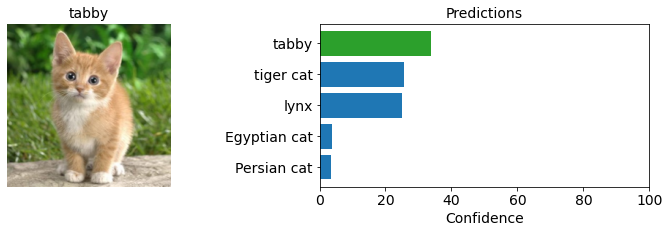

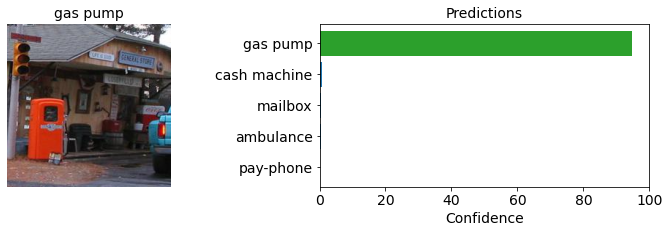

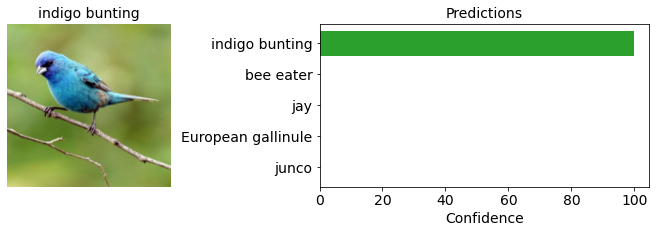

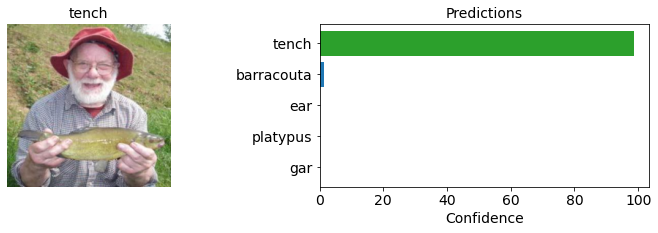

In [17]:
for i in range(preds.shape[0]):
    show_prediction(images[i], labels[i], preds[i])

<br><br>

# Fast Gradient Sign Method (FGSM) 

One of the first proposed methods for creating adversarial attacks is the Fast Gradient Sign Method (FGSM), developed by [Ian Goodfellow *et al.*](https://arxiv.org/pdf/1412.6572). FGSM is both easy to implement and conceptualize.

If for a given input image, the model is trained to change its weights based on the gradient of the objective function so that if we are to run the same input again we should obtain a better prediction, the idea behind FGSM is to try and change the input instead so as to maximize that objective function. In other words, if going against the gradient would help minimize the loss function, for FGSM we change the input according to the sign of the gradient (so that we maximize the loss).

The steps for running FGSM are as follows:
1. Get a batch of data (images and their true labels) and run the forward pass.
2. Compute the loss between the predicted and true labels.
3. Compute the gradient.
4. Change the input according to the sign of the gradient.

$$
    \tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_x J(\Theta, x, y))
$$

This attack can be performed very fast as it only requires one forward and backward pass. However, since we need to be able to compute the gradient with respect to the input of the network, this makes FGSM a **White-box adversarial attack** meaning that it assumes access to the model that we are trying to fool.

<br>

In [18]:
def FGSM(
    model: nn.Module, 
    images: Tensor, 
    labels: Tensor, 
    eps: float = 0.02
) -> tuple[Tensor, Tensor]:
    
    labels = labels.to(device)
    images = images.to(device)
    images = images.clone().requires_grad_()
    
    preds = model(images)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    
    grad_sign = torch.sign(images.grad)
    adv_images = images + eps * grad_sign
    
    return adv_images.detach(), grad_sign

The default value of $\epsilon = 0.02$ corresponds to changin a pixel value by about 1 in the range of $0$ to $255$. This is so that although the network is fooled, the change should be inpercievable to a human interpreter.

## Running the attack 

In [19]:
adv_images, noise = FGSM(model, images, labels)
preds_adv = model(adv_images.to(device))

## The results 

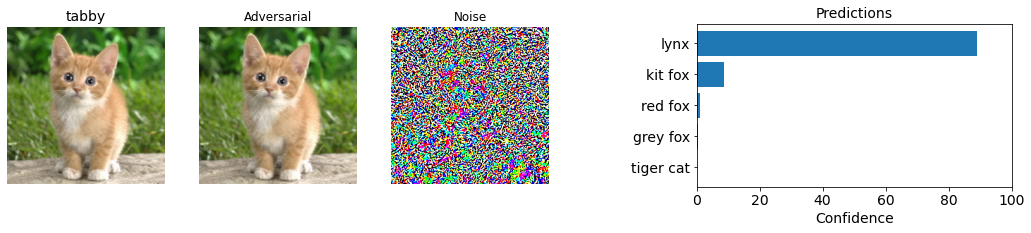

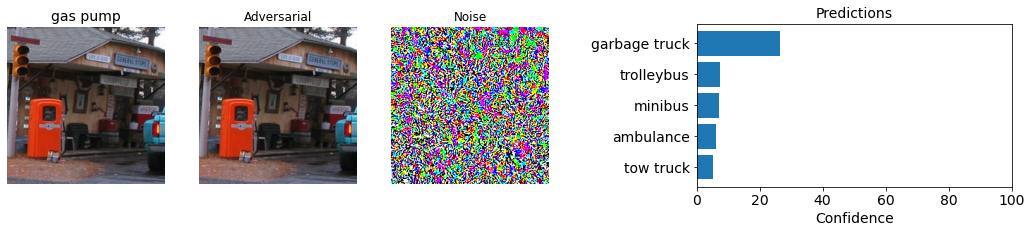

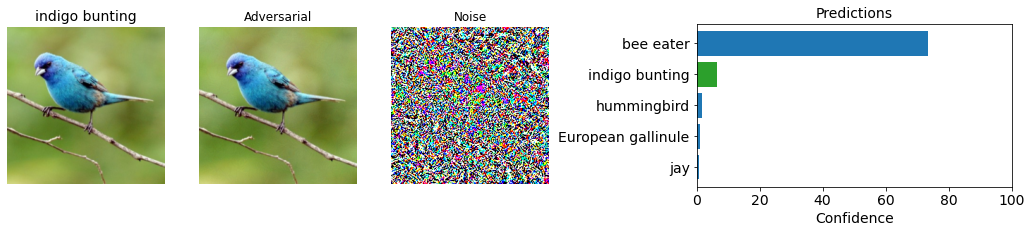

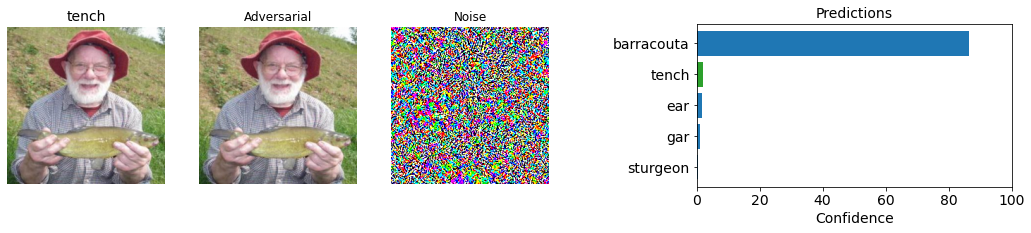

In [20]:
for i in range(preds.shape[0]):
    show_prediction(images[i], labels[i], preds_adv[i], adv_images[i], noise[i])

<br>

# But where is the model now looking?

In [21]:
image_bird = Image.open('data/batch/Indigo_Bunting.jpg').resize((224, 224))

In [22]:
heatmaps = grad_cam(images)
adv_heatmaps = grad_cam(adv_images)

## Grad-CAM heatmap on the original input

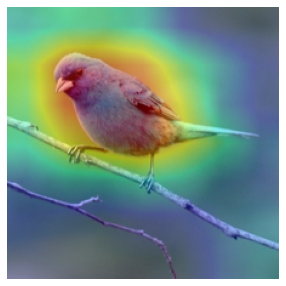

In [23]:
display(image_bird, heatmaps[2])

##  Grad-CAM heatmap on the adversarial example

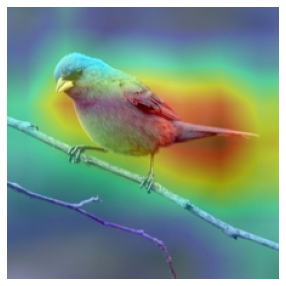

In [24]:
display(image_bird, adv_heatmaps[2])